# Romanian painting retrieval

# 1) Test romanian database

-> extract 200 pictures and memorize their output

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import pandas as pd


from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)

for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain1.pt'))
mobile_net.cuda()
mobile_net.eval()

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
base_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\"

folders = [ f.path for f in os.scandir(base_path) if f.is_dir() ]
classes_names = [ f.name for f in os.scandir(base_path) if f.is_dir() ]
classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

inv_class_mapping = {v: k for k, v in class_mapping.items()}


image_path_by_class = []
aux_str = []

for folder in folders:
    aux_str = folder + "//" + "*.jpg"
    image_path_by_class.append(glob.glob(aux_str))
print(classes_names)

['01_Byzantin_Iconography', '02_Early_Renaissance', '03_Northern_Renaissance', '04_High_Renaissance', '05_Baroque', '06_Rococo', '07_Romanticism', '08_Realism', '09_Impressionism', '10_Post_Impressionism', '11_Expressionism', '12_Symbolism', '13_Fauvism', '14_Cubism', '15_Surrealism', '16_AbstractArt', '17_NaiveArt', '18_PopArt']


In [4]:
labels = []
for index, class_path in enumerate(image_path_by_class):
  tmp = []
  for img_path in class_path:
    label = img_path.split("\\")[6]
    tmp.append(label)
  labels.append(tmp)

# len(labels)
targets = []
for label in labels:
    tmp = []
    for img_label in label:
      tmp.append(img_label)
    targets.append(tmp)


In [5]:
base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\"

# base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Net"

folders_rom = [ f.path for f in os.scandir(base_path_rom) if f.is_dir() ]

# print(folders_rom)

In [6]:
import pandas as pd

excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_wikiart_2.xlsx"

df = pd.read_excel(excel_name, sheet_name="Lista-completa")

print(df[['image_id']].loc[0]['image_id'])
print(df[['style']].loc[0]['style'])

adam-baltatu_after-rain
Impressionism


Adrian-Ghenie
E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\Adrian-Ghenie\adrian-ghenie_the-sunflowers-in-1937.jpg
Label:  Neo-Expressionism


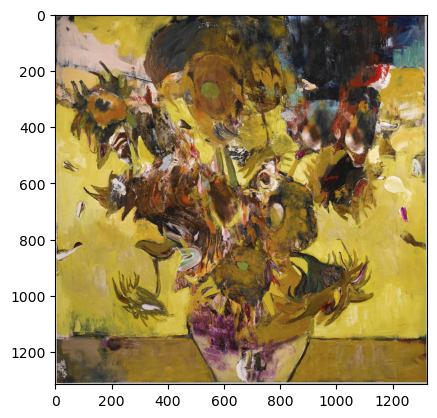

In [7]:
picture_index = 10
artist_index = 100

artist = df[['artist_slug']].loc[artist_index]['artist_slug']
artist = artist.title()
print(artist)

test_picture = base_path_rom + "\\" + artist + "\\" + df[['image_id']].loc[artist_index + picture_index]['image_id'] + ".jpg"
print(test_picture)

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
print("Label: ", df[['style']].loc[artist_index + picture_index]['style'])

Real label: Impressionism
tensor([[-12.3303, -10.6878,  -7.6278,  -8.0449,  -4.4673,  -5.6085,  -1.0949,
           0.1771,   0.8483,  -0.9012,  -4.1797,  -2.2398,  -4.2539,  -9.4437,
          -4.3484,  -4.4279,  -1.1946,  -2.7649]], grad_fn=<ToCopyBackward0>)
Predicted label:  09_Impressionism


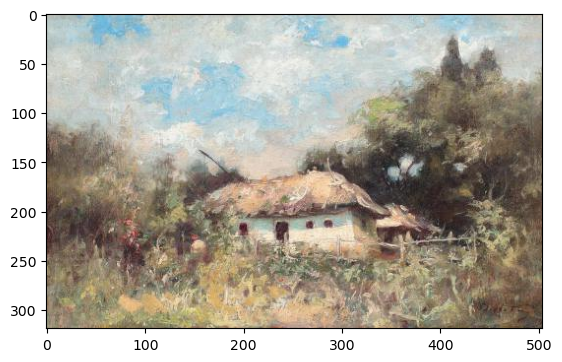

In [8]:
transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

picture = 10

# test_img = cv2.imread(train_data[picture])
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

picture_index = 55
artist_index = 1
artist = df[['artist_slug']].loc[artist_index]['artist_slug']
artist = artist.title()
test_picture = base_path_rom + "\\" + artist + "\\" + df[['image_id']].loc[artist_index + picture_index]['image_id'] + ".jpg"

img = cv2.imread(test_picture)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
print("Real label:", df[['style']].loc[artist_index + picture_index]['style'])

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]
# data.size()
# test_label = test_labels[picture].to(torch.device('cuda'))


predict = mobile_net.forward(data)
predict = predict.to(torch.device('cpu'))

print(predict)

predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_class_mapping[predict[0]])


In [ ]:
activation2 = {}
def get_activation(name):
    def hook(model, input, output):
        activation2[name] = output.detach()
    return hook

mobile_net.features[18].register_forward_hook(get_activation('Conv2dNormActivation'))
# mobile_net.classifier[1].register_forward_hook(get_activation('Conv2dNormActivation'))
predict = mobile_net(data)
activation2['Conv2dNormActivation']


# Extract the desired romanian pictures

Because we have 80 authors we will extract 5 pictures (=> 400 in total) from each author and calculate the features

In [78]:
## DO NOT RUN

path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_Paintings_400"


excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_only_features_labels.xlsx"
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features_2.xlsx"

data_frame = pd.read_excel(excel_name)
features=[]
# df = df.assign(features=[])

transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

activation2 = {}
def get_activation(name):
    def hook(model, input, output):
        activation2[name] = output.detach()
    return hook

activations = []

relu = nn.ReLU()

for index, image in enumerate(data_frame['image_id']):
        picture_path = path_rom + "\\" + image + ".jpg"

        img = cv2.imread(picture_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = transf(img)
        data = data.to(torch.device('cuda'))
        data = data[None, :]

        predict = mobile_net.forward(data)
        predict = relu(predict)
        predict = predict.to(torch.device('cpu'))

        mobile_net.features[18].register_forward_hook(get_activation('Conv2dNormActivation'))

        # predict = np.argmax(predict.detach().numpy(),axis=1)
        features.append(predict.detach().numpy())
        tmp = activation2['Conv2dNormActivation'].to(torch.device('cpu')).detach().numpy()
        activations.append(tmp)

print(len(features))
print(len(activations))
# print(activations)

data_frame.insert(2,column='features', value=features)
data_frame.to_excel(new_excel_name, index=False)

401
401


PermissionError: [Errno 13] Permission denied: 'E:\\Lucru\\ANUL II MASTER\\MLAV\\ProiectDificil\\Romanian_paintings\\romanian_with_features_2.xlsx'

In [66]:
print(len(activations[0][0]))


1280


In [64]:
excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features_2.xlsx"

data_frame = pd.read_excel(excel_name)

test = data_frame['activations'].loc[0]
print(len(test))
print(type(test))

# test_ft = data_frame['features'].loc[0].split("[[")[1]
# test_ft = test_ft.split("]]")[0]

# print(test_ft)
# print(type(test_ft))

# test = np.fromstring(test_ft, dtype=float, count=- 1, sep = ' ')

# print(test)
# print(type(test))

2716
<class 'str'>


In [10]:
from scipy.spatial import distance

def dist_euclidian(v1, v2):
    return distance.euclidean(v1, v2)

def euclidian_dist(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

# Painting Retrieval

- load a picture
- calculate distance between all features
- choose best 5

Label:  01_Byzantin
Predicted label:  01_Byzantin_Iconography
##################
35.032335262690154
35.032335262690154
##################
402
Best dist: [136 204 288 317   0]
16.061091389018415
15.596605432642372
15.34902858839829
14.798953969262843
0.0


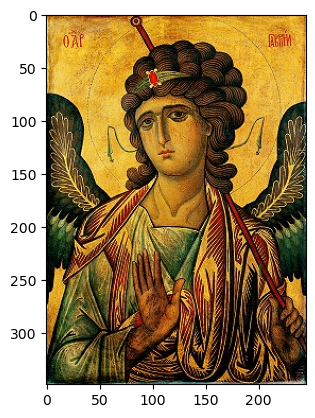

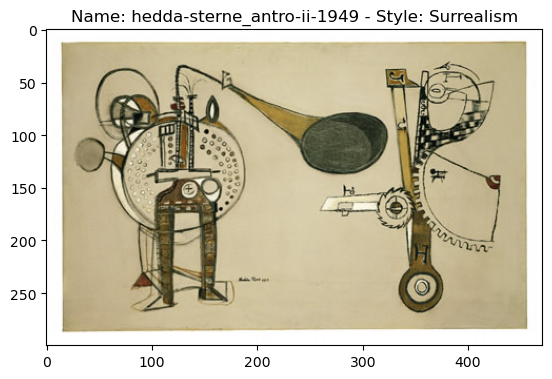

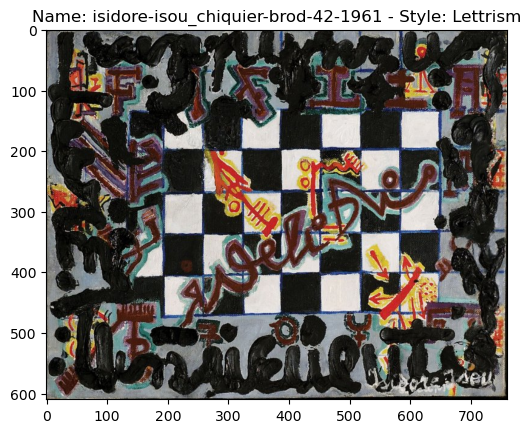

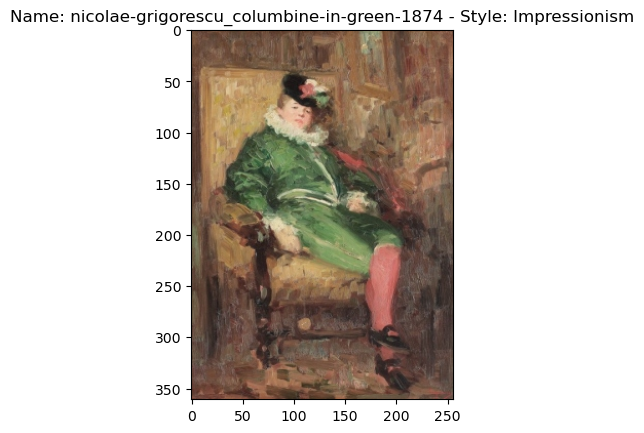

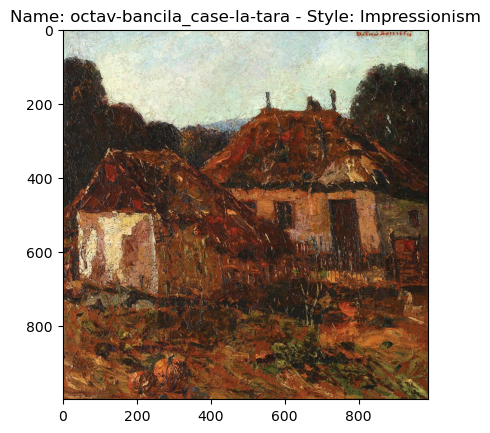

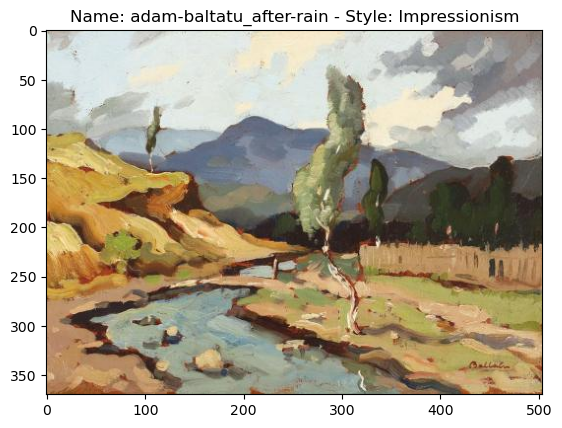

In [23]:
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"
base_path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\Images\\"

data_frame = pd.read_excel(new_excel_name)
# df = df.assign(features=[])

querry_features = []
features = []

transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# load features and transform them into np array
for feature in data_frame['features']:
        feature_tmp = feature.split("[[")[1]
        feature_tmp = feature_tmp.split("]]")[0]

        feature_np = np.fromstring(feature_tmp, dtype=float, count=- 1, sep = ' ')
        features.append(feature_np)


#### LOAD A PICTURE ####
# hardcode_picture_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\06_Rococo\Rococo (33).jpg"
# hardcode_label = "06_Rococo"
# hardcode_trigger = 5

hardcode_picture_path = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\01_Byzantin_Iconography\\Byzantin (3).jpg"
hardcode_label = "01_Byzantin"
hardcode_trigger = 1


img = cv2.imread(hardcode_picture_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
# print("Label: ", df[['style']].loc[artist_index + picture_index]['style'])
print("Label: ", hardcode_label)

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]

# CALCULATE ITS FEATURES
relu = nn.ReLU()

predict = mobile_net.forward(data)

predict = predict.to(torch.device('cpu'))

predict = np.argmax(predict.detach().numpy(),axis=1)
print("Predicted label: ",inv_class_mapping[predict[0]])

print("######" * 3)

print(dist_euclidian(predict, features[12]))
print(euclidian_dist(predict, features[12]))


print("######" * 3)


### BEGIN THE RETRIEVAL

distances = np.array(0)

for index, feature in enumerate(features):
        tmp = dist_euclidian(predict, feature)
        # distances.append(tmp)
        distances = np.append(distances, tmp)

print(len(distances))
# print(distances)
max_dist = np.argmax(distances)

max_dist2 = distances.argsort()[:5][::-1]
print("Best dist: {}".format(max_dist2))



# PRINT THE BEST APROXIMATES
new_excel_name = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_paintings\\romanian_with_features.xlsx"
data_frame2 = pd.read_excel(new_excel_name)

path_rom = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Romanian_Paintings_400"

for dist in max_dist2:
        print(distances[dist])
        picture_path = path_rom + "\\" + data_frame2['image_id'].loc[dist] + ".jpg"
        img = cv2.imread(picture_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title = "Name: " + data_frame2['image_id'].loc[dist] + " - Style: " + data_frame2['style'].loc[dist] 
        plt.figure()
        plt.imshow(img)
        plt.title(title)




In [19]:
print(distances)

[ 0.         18.58643775 25.23398071 17.5703974  24.54224343 18.27020632
 25.94026645 18.60657657 24.38250269 20.2796825  20.21292285 19.57210099
 20.23489275 35.03233526 22.20783367 27.09654124 22.56053775 29.04607018
 21.25409776 26.19077274 21.21810264 29.49744167 28.27092895 27.04303827
 30.4072909  20.11832246 26.99757618 23.61293548 25.76964905 34.19912224
 24.18444444 24.22063466 30.72154879 26.78841724 30.47845308 24.35659939
 21.54245755 19.19022594 19.30038849 26.31791157 24.92353965 20.87657161
 22.14098382 22.65317503 28.783855   21.5057916  22.1370583  25.02775624
 22.42236742 29.56392085 21.57228635 22.63010406 20.10952775 20.89208196
 23.36459366 25.16324274 23.09516152 27.09599906 26.64829439 32.90740985
 28.25268461 26.49664301 24.83191982 20.65357253 27.57516288 21.39028485
 26.43536735 23.15066803 20.0086556  21.95403829 19.94583388 18.40713823
 21.02651995 30.78305963 20.51070228 21.61854693 21.90666732 21.8382217
 29.3145695  28.9199554  27.08024588 33.47623558 30.